# 3D map simulation


### Objective
Simulate a 3D observation of a source with CTA using the CTA 1DC response and fit it with the assumed source model.


### Context

To simulate a specific observation, it is not always necessary to
simulate the full photon list. For many uses cases, simulating directly
a reduced binned dataset is enough: the IRFs reduced in the correct
geometry are combined with a source model to predict an actual number of
counts per bin. The latter is then used to simulate a reduced dataset
using Poisson probability distribution.

This can be done to check the feasibility of a measurement (performance
/ sensitivity study), to test whether fitted parameters really provide a
good fit to the data etc.

Here we will see how to perform a 3D simulation of a CTA observation,
assuming both the spectral and spatial morphology of an observed source.

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

## Simulation

We will simulate using the CTA-1DC IRFs shipped with gammapy. 

This time we utilise the IRFs from the South site.

In [1]:
from gammapy.irf import load_irf_dict_from_file
from gammapy.data import Observation, FixedPointingInfo, observatory_locations

In [3]:
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [4]:
livetime = 10.0 * u.hr
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
pointing = FixedPointingInfo(
    fixed_icrs=target_position.icrs,
)

In [5]:
from gammapy.maps import WcsGeom, MapAxis
from gammapy.datasets import MapDataset

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 2.0, 15), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [7]:
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpec

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using fake() to make a simulated counts maps. Keep in mind that it is important to specify the selection of the maps that you want to produce 

In [9]:
# Create an in-memory observation
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.42
	duration          : 36000.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [10]:
from gammapy.makers import MapDatasetMaker, SafeMaskMaker

In [11]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [12]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 811682 
  Total background counts         : 810346.54
  Total excess counts             : 1335.46

  Predicted counts                : 812153.07
  Predicted background counts     : 810346.54
  Predicted excess counts         : 1806.52

  Exposure min                    : 2.24e+04 m2 s
  Exposure max                    : 2.06e+11 m2 s

  Number of total bins            : 1260000 
  Number of fit bins              : 1251432 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 288719.50

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parame

In [13]:
dataset.counts.geom

Now use this dataset as you would in all standard analysis. 

In [14]:
# To plot, eg, counts:
dataset.counts.smooth(0.2 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Fit

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.


In [15]:
from gammapy.modeling import Fit

In [16]:
models_fit = models.copy()

In [17]:
# We want to fit the background in this case, so we will let the norm free but the spectral index frozen
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = False
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

In [18]:
dataset.models = models_fit
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawN

In [19]:
fit = Fit()
result = fit.run(datasets=[dataset])
stat_H1 = result.total_stat

<WCSAxes: >

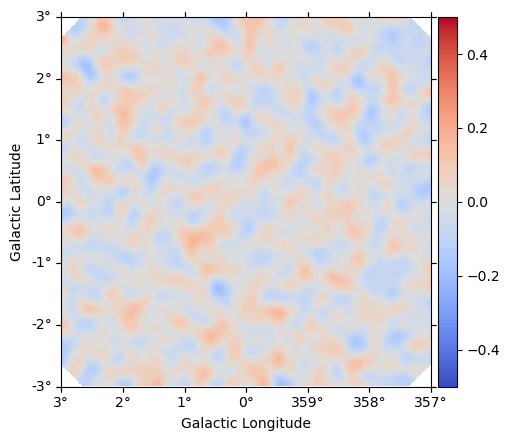

In [20]:
dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [21]:
from gammapy.estimators import FluxPointsEstimator

In [22]:
fpe = FluxPointsEstimator(energy_edges=energy_reco.edges)
flux_points = fpe.run(datasets=[dataset])

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

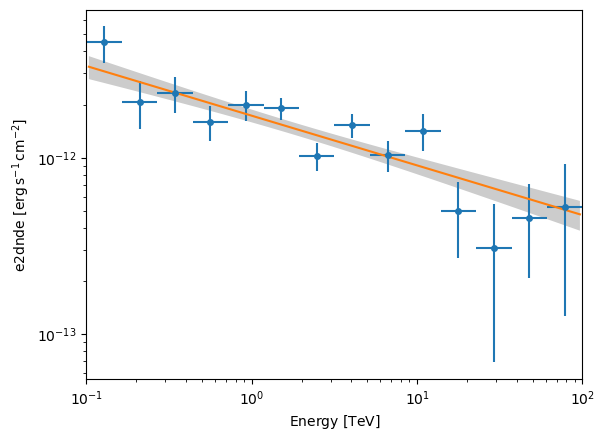

In [23]:
flux_points.plot(sed_type='e2dnde')
models_fit[0].spectral_model.plot([0.1,100]*u.TeV, sed_type='e2dnde')
models_fit[0].spectral_model.plot_error([0.1,100]*u.TeV, sed_type='e2dnde')

 ### Compare the injected and fitted models: 

In [24]:
print(
    "True model: \n",
    model_simu,
    "\n\n Fitted model: \n",
    models_fit["model-simu"],
)

True model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

 

 Fitted model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type 

Get the errors on the fitted parameters from the parameter table

## Estimating the LL of null hypothesis

In [25]:
# Fitting the data with just a background model. No source.
dataset.models = bkg_model
result = fit.run(datasets=[dataset])
stat_H0=result.total_stat
print(stat_H0)

289046.2234782165


In [26]:
# standard formula is TS=-2(LogLike1-LogLike0) but default stat in gammapy is -2 log(L)

TS = -(stat_H1-stat_H0) 
TS

332.63349210709566

## Your turn : estimating the significance of an Exponential Cutoff in the spectrum

Spectral models can be found here: https://docs.gammapy.org/1.2/user-guide/model-gallery/index.html

In [27]:
#Generate a new dataset with an Exponential Cutoff power-law with a E_cut = 50 TeV
#==> redefine a sky model and change the spectral model with an Exponential Cutoff power-law 
#Fit the dataset with a skymodel assuming an Exponential Cutoff power-law and save the likelihood value
#Fit the dataset with a skymodel assuming a power-law and save the likelihood value

#If you want to produce a histogram of reconstructed cut-off energy, you can run this analysis multiple times (i.e. an MCMC analysis)